In [35]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview, roc_results
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
data_length = 10000
stock = '11869'

In [58]:
df = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=False, include_test=False, length=None)
df.drop(columns=['bid', 'ask'], inplace=True)

In [59]:
df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df.index = df['datetime']
df = df.sort_index()
print(min(df['datetime']), max(df['datetime']), len(df))
df.dropna(inplace=True)
print(df.columns)
df[[c for c in df.columns if 'prev' in c]].head(5)

2013-09-02 09:00:00 2013-11-15 14:59:00 10567
Index(['datetime', 'bid_price', 'ask_price', 'mid_price', 'sum_sell_ask',
       'sum_buy_bid', 'mid_price_indicator', 'queue_imbalance'],
      dtype='object')


""
datetime
2013-09-02 09:00:00
2013-09-02 09:01:00
2013-09-02 09:02:00
2013-09-02 09:05:00
2013-09-02 09:06:00


In [60]:
df[[c for c in df.columns if 'avg_2' in c]].plot()

TypeError: Empty 'DataFrame': no numeric data to plot

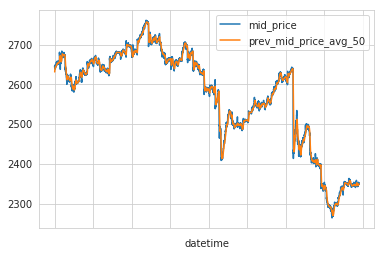

In [52]:
df[['mid_price', 'prev_mid_price_avg_50']].plot()

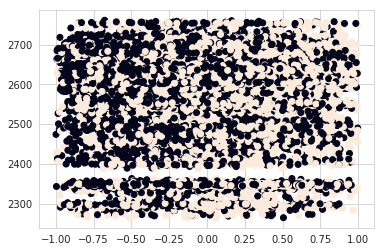

In [61]:
plt.scatter(df['queue_imbalance'], df['mid_price'], c=df['mid_price_indicator'])

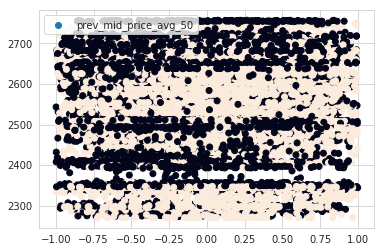

In [54]:
plt.scatter(df['queue_imbalance'], df['prev_mid_price_avg_50'], c=df['mid_price_avg_indicator_50'])
plt.legend()

In [62]:
def logistic_regression(df):
    clf = LogisticRegressionCV(fit_intercept=True, solver='sag')
    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator'].values.ravel()
    clf.fit(X, y)
    return clf

def logistic_regression_avg(df):
    clf = LogisticRegressionCV(fit_intercept=True, solver='sag')
    X = df[['queue_imbalance', 'prev_mid_price_avg_50']]
    y = df['mid_price_indicator'].values.ravel()
    clf.fit(X, y)
    return clf
clf1 = logistic_regression(df)
clf2 = logistic_regression_avg(df)

In [63]:
pred2 = clf2.predict(df[['queue_imbalance', 'prev_mid_price_avg_50']])
pred1 = clf1.predict(df[['queue_imbalance']])

In [64]:
roc_auc_score(df['mid_price_indicator'], pred1), roc_auc_score(df['mid_price_indicator'], pred2)

0.5738250185403003

## Data length

In [7]:
lengths = []
for s in list(roc_results.results.keys()):
    dff = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, include_test=False, length=None)
    lengths.append({'stock': s, 'lenght': len(dff)})
df_length = pd.DataFrame(lengths)
df_length.head()

,lenght,stock
0,8627,11399
1,9883,2645
2,17080,9069
3,16533,9063
4,7517,9926


In [55]:
df_length.sort_values(by='lenght', ascending=False)

,lenght,stock
21,17676,9064
33,17551,9062
27,17518,11244
9,17245,9061
2,17080,9069
3,16533,9063
54,15986,9265
8,15876,10166
73,15689,9269
39,15554,9067


In [56]:
df_length.describe()

,lenght
count,98.000000
mean,10610.367347
std,3397.063242
min,5489.000000
25%,7660.750000
50%,10377.000000
75%,13639.000000
max,17676.000000
